In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import tqdm as 

In [2]:
def ndi(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    
    NDI = 128 * ((G - R)/(G + R) + 1)
    
    return NDI.astype('uint8')

In [3]:
def exg(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    sum_RGB = R + G + B
    EXG = 64 *((2 * G - R - B) / sum_RGB + 2)
    
    return EXG.astype('uint8')

In [4]:
def otsu_binarization(img, verbose=False):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if verbose:
        print(ret3)
    return th3

In [5]:
def fixed_binarization(img, th = 131, verbose=False):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,th1 = cv2.threshold(blur,th,255,cv2.THRESH_BINARY)
    if verbose:
        print(ret)
    return th1

In [6]:
def mean_binarization(img):
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return th3

In [7]:
def imshow(img, verbose=True, gray=True):
    if verbose:
        plt.figure()
        if gray:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

In [8]:
def plant_detect(path, verbose=False):
    # Read image
    img_cv = cv2.imread(path)
    img = img_cv[:, :, ::-1]
    imshow(img, verbose=verbose, gray=False)
    
    # Calculate enhanced image
    ndi_img = ndi(img)
    imshow(ndi_img, verbose=verbose)
    
    exg_img = exg(img)
    imshow(exg_img, verbose=verbose)
    
    # Segmentaion
    ndi_binary_img = otsu_binarization(ndi_img, verbose=verbose)
    imshow(ndi_binary_img, verbose=verbose)

    exg_binary_img = otsu_binarization(exg_img, verbose=verbose)
    imshow(exg_binary_img, verbose=verbose)

    kernel = np.ones((5,5),np.uint8)
    exg_dilation_img = cv2.dilate(exg_binary_img,kernel,iterations = 1)
    mask = ((ndi_binary_img != 0) & (exg_dilation_img == 0))
    thistle_img = np.zeros_like(ndi_binary_img)
    thistle_img[mask] = 255
    imshow(thistle_img, verbose=verbose)
    
    #
    plant_img = np.copy(img)
    plant_img[ndi_binary_img==0]=[0, 0, 0]
    imshow(plant_img, verbose=verbose, gray=False)
    
    # Find contour
    img2 = np.copy(img)
    contours, _ = cv2.findContours(thistle_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (0,255,0), 2)
            
    contours, _ = cv2.findContours(exg_binary_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w * h > 900:
            cv2.rectangle(img2, (x,y), (x+w,y+h), (255,0,0), 2)
            
    imshow(img2, verbose=verbose, gray=False)
    
    return img, img2

138.0
141.0


True

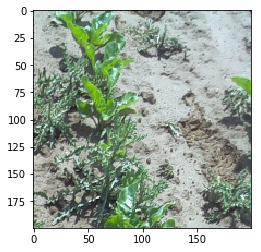

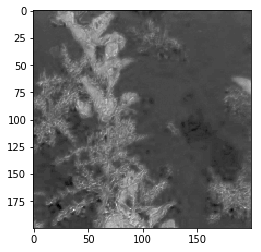

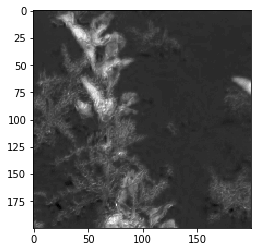

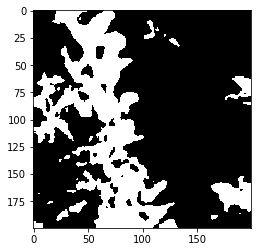

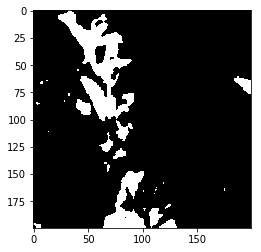

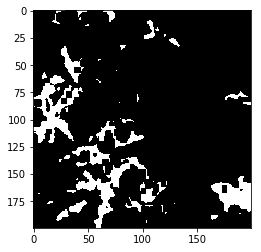

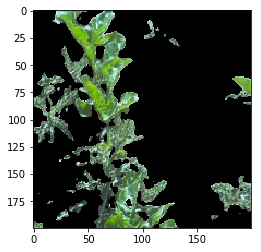

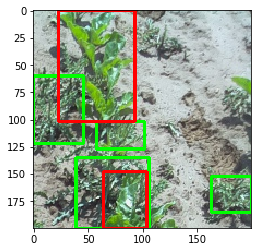

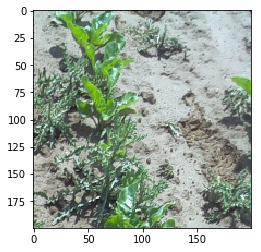

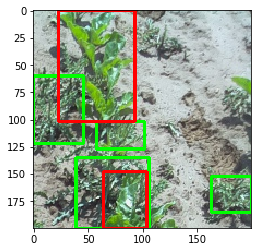

In [10]:
img, result = plant_detect('data/im_19.jpg', verbose=True)
imshow(img, gray=False)
imshow(result, gray=False)
cv2.imwrite('results/im_19.jpg', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

In [12]:
data_path = 'data'
result_path = 'result'
for file in tqdm(os.listdir(data_path)):
    if '.jpg' in file:
        img, result = plant_detect(os.path.join(data_path, file))
#         fig, (ax1, ax2) = plt.subplots(1, 2)
#         ax1.imshow(img, cmap='gray')
#         ax2.imshow(result, cmap='gray')
        cv2.imwrite(os.path.join(result_path, file), result)

TypeError: 'module' object is not callable